In [66]:
# import pylsl
%matplotlib qt5

import mne
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [67]:
def read_data(filename, show=True, event_id=[1, 2]):
    raw=mne.io.read_raw_edf(filename, preload=True)
    raw_hil = raw.copy().filter(200, 1000).apply_hilbert(envelope=True).filter(0, 20)
    events=mne.events_from_annotations(raw_hil)[0]
    epochs = mne.Epochs(raw_hil, event_id=event_id, 
                        events=events, 
                        tmin=0, tmax=2, 
                        preload=True, 
                        baseline=None).apply_hilbert(envelope=True)
    if show:
        raw_hil.plot()
    return epochs

In [87]:
#Read all fingers
pointing_epochs = read_data('Data/Pointing_finger.edf', show=False)
middle_epochs = read_data('Data/Middle_finger.edf', show=False)
ring_epochs = read_data('Data/Ring_finger.edf', show=False)
thumb_epochs = read_data('Data/Thumb.edf', show=False)

Extracting EDF parameters from D:\Education\Skoltech\CNBR\Остеоинтеграция\Experiments\EMG\Data\Pointing_finger.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 664999  =      0.000 ...   133.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-

In [89]:
pointing_epochs.event_id = {'Pointing forward': 1, 'Pointing backward': 2}
middle_epochs.events = np.where(middle_epochs.events == 1, 3, middle_epochs.events)
middle_epochs.events = np.where(middle_epochs.events == 2, 4, middle_epochs.events)
middle_epochs.event_id = {'Middle forward': 3, 'Middle backward': 4}
ring_epochs.events = np.where(ring_epochs.events == 1, 5, ring_epochs.events)
ring_epochs.events = np.where(ring_epochs.events == 2, 6, ring_epochs.events)
ring_epochs.event_id = {'Ring forward': 5, 'Ring backward': 6}
thumb_epochs.events = np.where(thumb_epochs.events == 1, 7, thumb_epochs.events)
thumb_epochs.events = np.where(thumb_epochs.events == 2, 8, thumb_epochs.events)
thumb_epochs.event_id = {'Thumb forward': 7, 'Thumb backward': 8}
# 
# all_epochs = mne.concatenate_epochs([thumb_epochs, middle_epochs], verbose=True)

In [97]:
all_epochs = mne.concatenate_epochs([pointing_epochs, middle_epochs, ring_epochs, thumb_epochs], verbose=True)

Not setting metadata
Not setting metadata
196 matching events found
No baseline correction applied
0 bad epochs dropped


Extracting EDF parameters from D:\Education\Skoltech\CNBR\Остеоинтеграция\Experiments\EMG\Data\Thumb.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 464999  =      0.000 ...    93.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2e+02 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 250.00 Hz (-6 dB cutoff frequency: 1125.00 Hz)
- Filter length: 331 samples (0.066 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal low

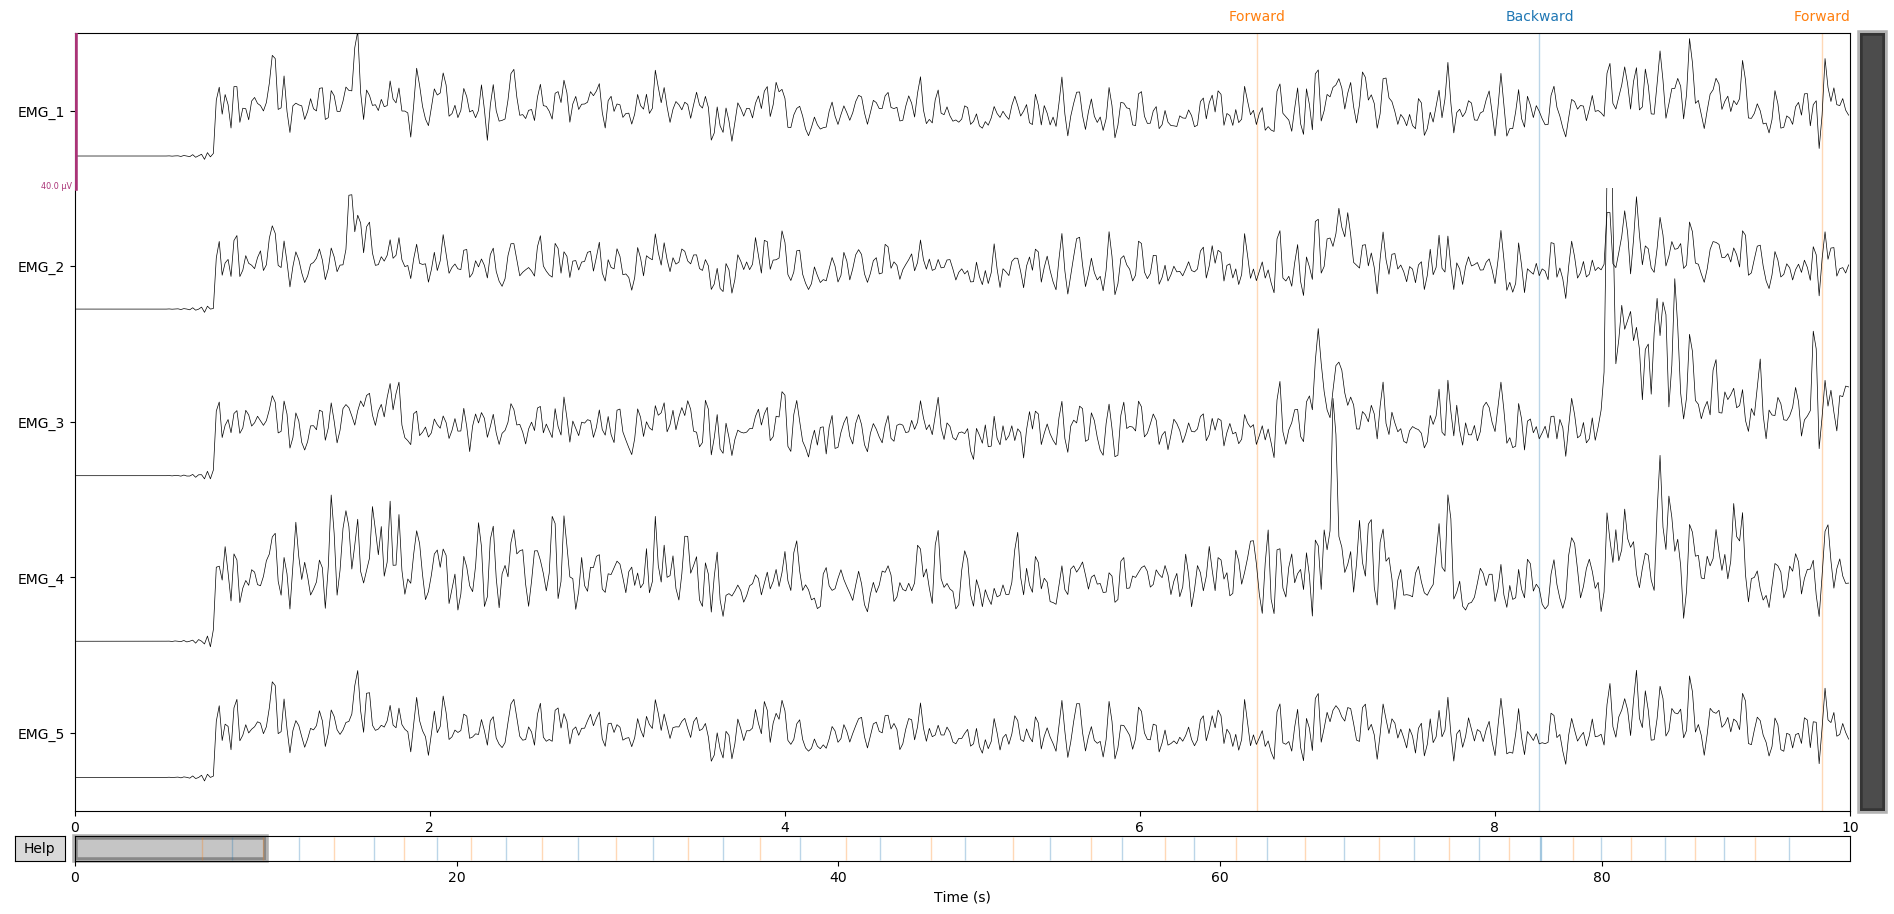

Channels marked as bad: none


In [32]:
raw=mne.io.read_raw_edf('Data/Thumb.edf', preload=True)
raw_hil = raw.copy().filter(200, 1000).apply_hilbert(envelope=True).filter(0, 20)
events=mne.events_from_annotations(raw_hil)[0]
epochs = mne.Epochs(raw_hil, event_id=[1,2], 
                    events=events, 
                    tmin=0, tmax=2, 
                    preload=True, 
                    baseline=None).apply_hilbert(envelope=True)
raw_hil.plot()

In [99]:
X=[]
FS=5000
Time=2
Wind=1
ch_num=5

for i in range(all_epochs._data.shape[0]):
    channel_names = np.arange(ch_num).astype(str).tolist()
    channel_types = ['eeg']*ch_num
    sfreq = FS
    info = mne.create_info(channel_names, sfreq, channel_types)
    raw = mne.io.RawArray(all_epochs._data[i], info, verbose=False)
    
    raw.filter(200, 1000)
    x__=raw.apply_hilbert(envelope=True).resample(10).get_data()
    x_=x__.flatten().reshape(1,-1)
    X.append(x_) 

In [100]:
X=np.array(X).squeeze()

In [101]:
X.shape

(196, 100)

In [104]:
y = all_epochs.events[:,-1].flatten()

In [105]:
y.shape

(196,)

In [124]:
pca = PCA(8)

pv = pca.fit_transform(X)
classifier = SVC(C=0.8, kernel='rbf', probability=True)

classifier.fit(pv, y)
yp = classifier.predict_proba(pv)

classifier.score(pv, y)#, roc_auc_score(y, yp, multi_class='ovr')

0.5153061224489796

In [115]:
fig = plt.figure()
plt.scatter(pv[:,0],pv[:,1],c=y)
plt.show()